In [1]:
import pandas as pd
import scanpy as sc
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import random

In [2]:
import scvi
import scanpy as sc

from matplotlib.pyplot import rc_context
sc.set_figure_params(dpi=100)

/home/toby/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/toby/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


In [3]:
adata = sc.read_h5ad('../../h5ad/h5seurat_myeloid_BP2_unintegrated_annotated2.h5ad') #raw data

In [100]:
adata

AnnData object with n_obs × n_vars = 100493 × 36600
    obs: 'DiseaseState', 'Sex', 'Age', 'Pair', 'GEM', 'louvain'
    uns: 'DiseaseState_colors', 'louvain', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    layers: 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

/home/to/miniconda3/envs/scVI/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


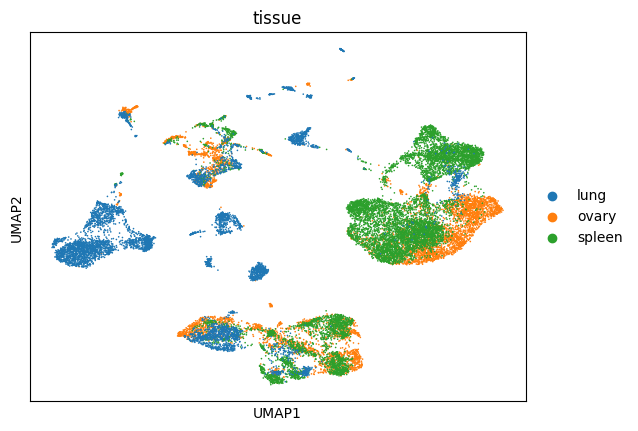

In [6]:
sc.pl.umap(adata, color='tissue')

/home/to/miniconda3/envs/scVI/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


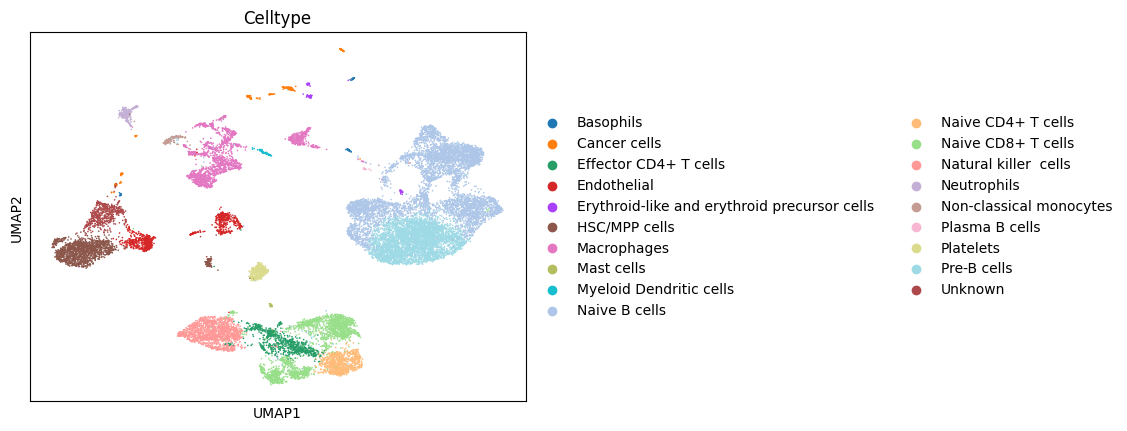

In [10]:
sc.pl.umap(adata, color='Celltype')

In [9]:
adata.X

<21890x34212 sparse matrix of type '<class 'numpy.float64'>'
	with 39823598 stored elements in Compressed Sparse Column format>

In [14]:
adata.layers

Layers with keys: 

In [15]:
scvi.model.SCVI.setup_anndata(adata, categorical_covariate_keys=["tissue"],
                             continuous_covariate_keys=['percent.mt', 'nFeature_RNA'])

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/home/to/miniconda3/envs/scVI/lib/python3.8/site-packages/scvi/data/fields/_layer_field.py:90: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(
/home/to/miniconda3/envs/scVI/lib/python3.8/site-packages/scvi/data/_utils.py:119: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  warnings.warn(


In [16]:
model = scvi.model.SCVI(adata)

In [17]:
model

SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal
Training status: Not Trained
Model's adata is minified?: False

In [18]:
model.train() #may take a while without GPU

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA Graphics Device') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/365:   0%|                                      | 0/365 [00:00<?, ?it/s]

/home/to/miniconda3/envs/scVI/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/to/miniconda3/envs/scVI/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 2/365:   0%|    | 1/365 [00:13<1:22:44, 13.64s/it, loss=5.28e+03, v_num=1]

/home/to/miniconda3/envs/scVI/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:476: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 365/365: 100%|█| 365/365 [1:17:58<00:00, 12.98s/it, loss=4.54e+03, v_num=1

`Trainer.fit` stopped: `max_epochs=365` reached.


Epoch 365/365: 100%|█| 365/365 [1:17:58<00:00, 12.82s/it, loss=4.54e+03, v_num=1


In [19]:
latent = model.get_latent_representation() #this is what you will use to cluster now instead of PCs like normal

In [20]:
latent.shape

(21890, 10)

In [21]:
adata.obsm['X_scVI'] = latent

In [18]:
adata.layers['scvi_normalized'] = model.get_normalized_expression(library_size = 1e4)

NameError: name 'model' is not defined

/home/to/miniconda3/envs/scVI/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/to/miniconda3/envs/scVI/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


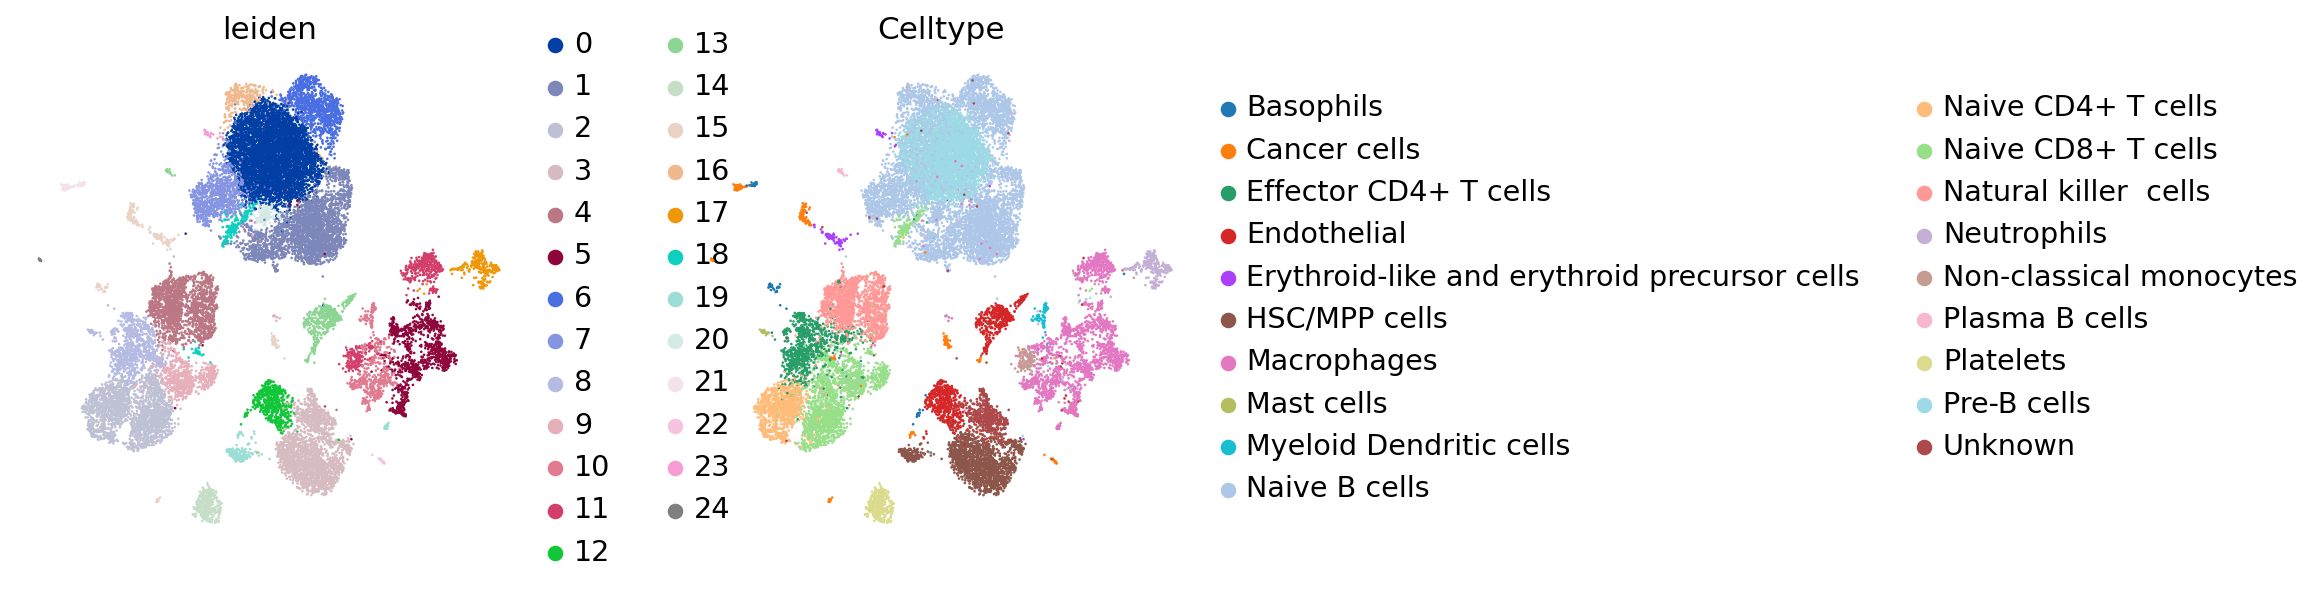

In [28]:
with rc_context({'figure.figsize': (4, 4)}):
    sc.pl.umap(adata, color = ['leiden', 'Celltype'], frameon = False)

In [138]:
#find markers of each cluster
df = model.differential_expression(groupby = 'leiden')

In [137]:
df

In [ ]:
markers = {}
for c in adata.obs.leiden.cat.categories:
    cell_df = df.loc[df.group1 == c]
    markers[c] = cell_df.index.tolist()[:2]

In [ ]:
sc.pl.dotplot(adata, markers, groupby = 'leiden', swap_axes = True,
             use_raw = True, standard_scale = 'var', dendrogram = True)

In [5]:
import numpy as np
import pandas as pd
import scanpy as sc
from time import time
from scsampler import scsampler
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

/home/toby/miniconda3/envs/scvi/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/toby/miniconda3/envs/scvi/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/toby/miniconda3/envs/scvi/lib/python3.9/site-packages/umap/distances.py:

scanpy==1.9.3 anndata==0.9.1 umap==0.5.3 numpy==1.24.3 scipy==1.9.3 pandas==2.0.2 scikit-learn==1.2.2 statsmodels==0.14.0 python-igraph==0.10.4 pynndescent==0.5.10


/home/toby/miniconda3/envs/scvi/lib/python3.9/site-packages/umap/umap_.py:660: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()


In [5]:
adata

AnnData object with n_obs × n_vars = 21890 × 34091
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'sample_ID', 'percent.mt', 'RNA_snn_res.0.5', 'seurat_clusters', 'customclassif', 'celltype_treatment', 'RNA_snn_res.0.4', 'tissue', 'Celltype', 'RNA_snn_res.0.6', 'celltype_tissue', '_scvi_batch', '_scvi_labels', 'leiden', '_scvi_raw_norm_scaling'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'ribo'
    uns: 'Celltype_colors', '_scvi_manager_uuid', '_scvi_uuid', 'leiden', 'leiden_colors', 'neighbors', 'tissue_colors', 'umap'
    obsm: 'X_pca', 'X_scVI', 'X_scvi', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    layers: 'scvi_normalized'
    obsp: 'connectivities', 'distances'

In [84]:
cell_types = ['Naive CD4+ T cells', 'Naive CD8+ T cells', "Effector CD4+ T cells"]

In [85]:
at2 = adata[adata.obs['Celltype'].isin(cell_types)]
sc.pp.filter_genes(at2, min_cells=100)
sc.pp.highly_variable_genes(at2, subset=True, n_top_genes = 2000)

filtered out 24350 genes that are detected in less than 100 cells


/home/to/miniconda3/envs/scVI/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [ ]:
at2

AnnData object with n_obs × n_vars = 3868 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'sample_ID', 'percent.mt', 'RNA_snn_res.0.5', 'seurat_clusters', 'customclassif', 'celltype_treatment', 'RNA_snn_res.0.4', 'tissue', 'Celltype', 'RNA_snn_res.0.6', 'celltype_tissue', '_scvi_batch', '_scvi_labels', 'leiden', '_scvi_raw_norm_scaling'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'ribo', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Celltype_colors', '_scvi_manager_uuid', '_scvi_uuid', 'leiden', 'leiden_colors', 'neighbors', 'tissue_colors', 'umap', 'hvg'
    obsm: 'X_pca', 'X_scVI', 'X_scvi', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    layers: 'scvi_normalized'
    obsp: 'connectivities', 'distances'

AnnData object with n_obs × n_vars = 3868 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'sample_ID', 'percent.mt', 'RNA_snn_res.0.5', 'seurat_clusters', 'customclassif', 'celltype_treatment', 'RNA_snn_res.0.4', 'tissue', 'Celltype', 'RNA_snn_res.0.6', 'celltype_tissue', '_scvi_batch', '_scvi_labels', 'leiden', '_scvi_raw_norm_scaling'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'ribo', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Celltype_colors', '_scvi_manager_uuid', '_scvi_uuid', 'leiden', 'leiden_colors', 'neighbors', 'tissue_colors', 'umap', 'hvg'
    obsm: 'X_pca', 'X_scVI', 'X_scvi', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    layers: 'scvi_normalized'
    obsp: 'connectivities', 'distances'

In [101]:
adata.obs.DiseaseState

0         HC
1         HC
2         HC
3         HC
4         HC
          ..
100488    HC
100489    HC
100490    HC
100491    HC
100492    HC
Name: DiseaseState, Length: 100493, dtype: category
Categories (5, object): ['HC', 'Nonprogressor', 'PPMS', 'Progressor', 'RRMS']

In [136]:
small_ppms = adata[adata.obs.DiseaseState == "PPMS"]
small_nonppms = adata[adata.obs.DiseaseState != "PPMS"]

In [137]:
small_ppms

View of AnnData object with n_obs × n_vars = 10977 × 36600
    obs: 'DiseaseState', 'Sex', 'Age', 'Pair', 'GEM', 'louvain'
    uns: 'DiseaseState_colors', 'louvain', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    layers: 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

In [138]:
small_ppms = scsampler(small_ppms, fraction = 0.1, copy = True) 
small_nonppms = scsampler(small_nonppms, fraction = 0.1, copy = True) 

/Users/tbl11/miniconda3-intel/envs/scVI/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [139]:
small_nonppms

AnnData object with n_obs × n_vars = 8951 × 36600
    obs: 'DiseaseState', 'Sex', 'Age', 'Pair', 'GEM', 'louvain'
    uns: 'DiseaseState_colors', 'louvain', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    layers: 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

In [140]:
test = small_ppms.concatenate(small_nonppms, index_unique=None)

/Users/tbl11/miniconda3-intel/envs/scVI/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/tbl11/miniconda3-intel/envs/scVI/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/Users/tbl11/miniconda3-intel/envs/scVI/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavou

In [141]:
test.obs_names

Index(['73618', '22078', '22363', '73759', '73120', '20718', '24535', '26555',
       '73610', '74329',
       ...
       '16099', '16099', '16099', '16099', '16099', '16099', '16099', '16099',
       '16099', '16099'],
      dtype='object', length=10048)

In [156]:
train = adata[~adata.obs.DiseaseState.isin(test.obs_names)]

In [153]:
adata

AnnData object with n_obs × n_vars = 100493 × 36600
    obs: 'DiseaseState', 'Sex', 'Age', 'Pair', 'GEM', 'louvain'
    uns: 'DiseaseState_colors', 'louvain', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    layers: 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

In [143]:
train

View of AnnData object with n_obs × n_vars = 100493 × 36600
    obs: 'DiseaseState', 'Sex', 'Age', 'Pair', 'GEM', 'louvain'
    uns: 'DiseaseState_colors', 'louvain', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    layers: 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

In [144]:
def label_infection(x):
    if 'PPMS' in x:
        return 1
    else:
        return 0

In [145]:
y = train.obs.DiseaseState.map(label_infection)

In [146]:
sel = RandomForestClassifier(n_jobs = 10, n_estimators=100)
sel.fit(train.X, y)

RandomForestClassifier(n_jobs=10)

In [147]:
predictions = sel.predict(test.X)

In [148]:
lables = test.obs.DiseaseState.map(label_infection)

In [149]:
metrics.accuracy_score(lables, predictions)

1.0

In [150]:
df = pd.DataFrame(sel.feature_importances_,
                  index = train.var_names).sort_values(0, ascending = False)

In [151]:
df

,0
RPS27,0.007564
RPL34,0.007106
RPL39L,0.006125
SNHG5,0.004500
RPL37A,0.004351
...,...
LINC02564,0.000000
PARD6G,0.000000
AC068473.5,0.000000
AC018445.1,0.000000


In [152]:
df.to_csv('../stats/PPMS_females_RF_classifier.csv')  

In [16]:
non_mito_genes_list = [name for name in adata.var_names if not name.startswith('Rpl')]
adata = adata[:, non_mito_genes_list]

In [17]:
adata

View of AnnData object with n_obs × n_vars = 21890 × 34091
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'sample_ID', 'percent.mt', 'RNA_snn_res.0.5', 'seurat_clusters', 'customclassif', 'celltype_treatment', 'RNA_snn_res.0.4', 'tissue', 'Celltype', 'RNA_snn_res.0.6', 'celltype_tissue', '_scvi_batch', '_scvi_labels', 'leiden', '_scvi_raw_norm_scaling'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'ribo'
    uns: 'Celltype_colors', '_scvi_manager_uuid', '_scvi_uuid', 'leiden', 'leiden_colors', 'neighbors', 'tissue_colors', 'umap'
    obsm: 'X_pca', 'X_scVI', 'X_scvi', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    layers: 'scvi_normalized'
    obsp: 'connectivities', 'distances'

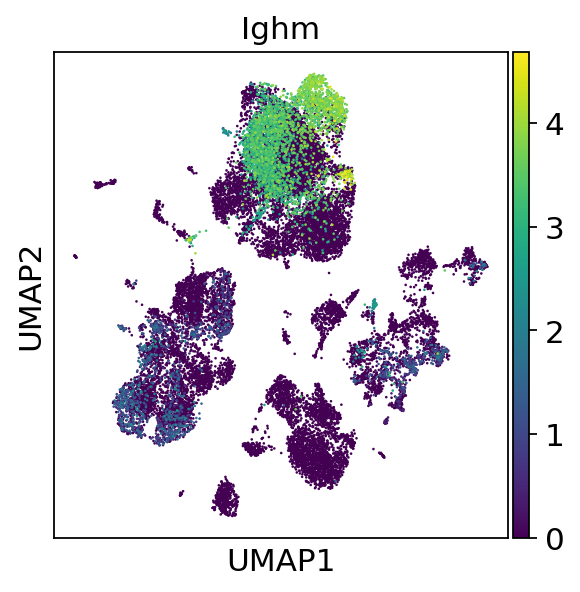

In [83]:
# rc_context is used for the figure size, in this case 4x4
with rc_context({'figure.figsize': (4, 4)}):
    sc.pl.umap(adata, color='Ighm')

/home/to/miniconda3/envs/scVI/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/to/miniconda3/envs/scVI/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


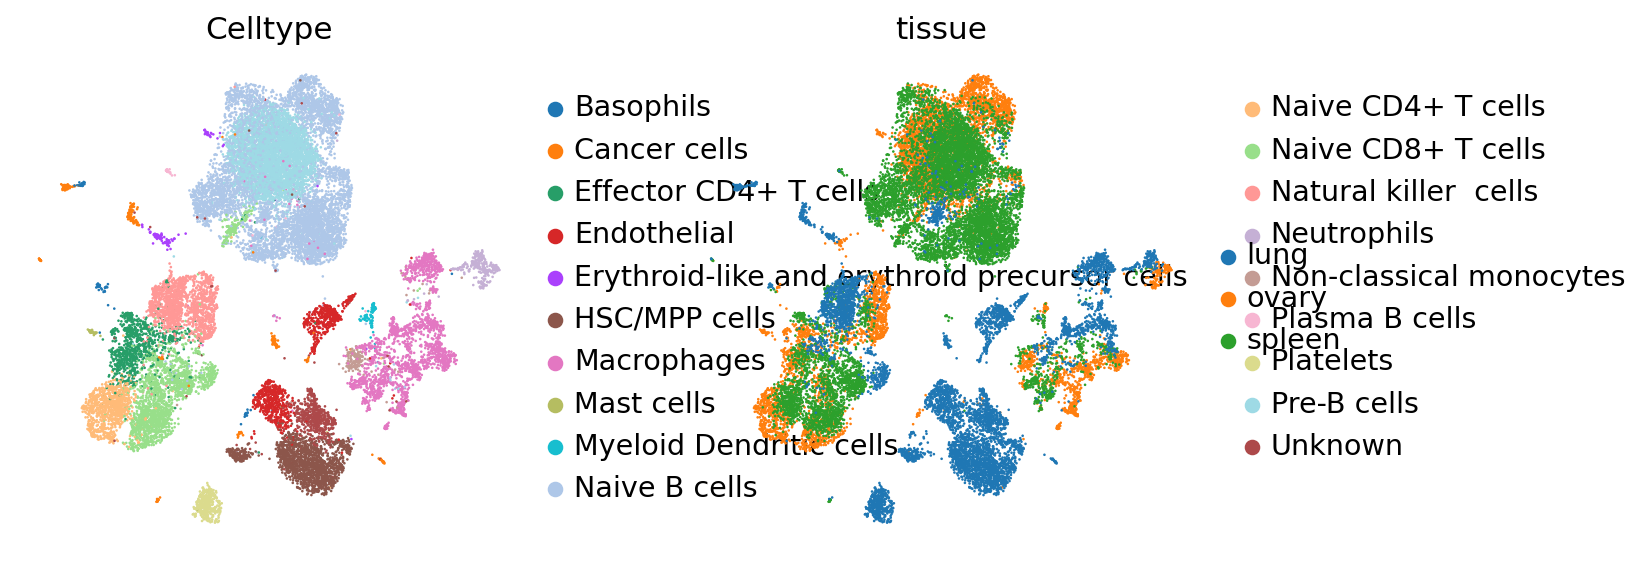

In [48]:
sc.pl.umap(adata, color = ['Celltype', 'tissue'], frameon = False)